# Retail Customer Dataset Profiling 

In this notebook, the dataset will be profiled in order to get a better understanding of the data and its structure. This will help to identify any potential issues or areas for improvement in the ETL process when migrating into PostgreSQL.

Profiling means to highlight how many files are in the data directory and what data quality issues exist within them. It includes comparing datasets schemas to identify any discrepancies or inconsistencies.

#### Workflow Profiling
1. Load environment variables from `.env` file.
2. Define paths for data and output directories.
3. List all data files in the specified data directory.
4. Profile each data file to extract schema, insights, and statistics.
5. Compare schemas across all profiled files to identify common and unique columns.

#### Profiling Insights
The profiling process generates a comprehensive overview of each dataset: 
- number of rows, 
- number of columns, 
- column names, 
- data types, 
- files delimiters,
- file formats
- missing values
- unique values
- duplicate rows


## Imports & Setup

Run this section to import necessary libraries and set up paths.

### Basic Imports

In [1]:
import sys
import os
from pathlib import Path
from dotenv import load_dotenv, dotenv_values
import polars as pl
import pprint
import json

# add src/ to Python path
sys.path.append(os.path.abspath(os.path.join('..')))

from src.utils.dataset_profiling import profile_files, compare_schemas, entry_error_proportions
from src.utils.routing import get_project_path, create_file_path_list, env_config
from src.utils.reporting import create_profile_report

from src.etl.tables.schemas_regex import transactions_patterns, products_patterns
import src.utils.data_validation as pv

### Load Environment Variables

In [2]:
config = env_config()
pprint.pprint(config)

Environment variables loaded from /Users/lucpellinger/Documents/Projects/data-engineering-challenge/.env: True
Check if Dataset Directory is correct: src/assets/dataset/raw/transactions
{'DATA_DIR': 'src/assets/dataset/raw/transactions',
 'DEFAULT_NULL_TOKENS': {'',
                         '#NO VALUE',
                         '#NO_VALUE',
                         '#no_value',
                         'missing',
                         'n/a',
                         'na',
                         'nan',
                         'none',
                         'null'},
 'METADATA_DIR': 'src/assets/metadata',
 'OUTPUT_DIR': 'src/assets/analysis',
 'PGADMIN_DEFAULT_EMAIL': 'local@admin.com',
 'PGADMIN_DEFAULT_PASSWORD': 'rootnew',
 'POSTGRES_DB': 'local_postgres_db',
 'POSTGRES_HOST': 'localhost',
 'POSTGRES_PASSWORD': 'root',
 'POSTGRES_PORT': '5432',
 'POSTGRES_SCHEMA': 'public',
 'POSTGRES_USER': 'local',
 'PROCESSED_DIR': 'src/assets/dataset/processed',
 'PROCESSED_DIR_PRODUCTS': 

### Dataset Paths Setup

In [3]:
### Dataset Paths Setup
# create list of data files in data directory
root_path = get_project_path("ROOT", config)  # Get the root path
raw_data_path = get_project_path("DATA_DIR", config)
output_path = get_project_path("OUTPUT_DIR", config)
processed_path = get_project_path("PROCESSED_DIR", config)
processed_path_transactions = get_project_path("PROCESSED_DIR_TRANSACTIONS", config)
processed_path_products = get_project_path("PROCESSED_DIR_PRODUCTS", config)
product_path = get_project_path("PRODUCT_DIR", config)


We verified that all necessary packages are installed and imported. Additionally, we set up the environment variables to ensure that the paths to the data and output directories are correctly configured. We can see that we can also access the variables from the `.env` file.

### File Listing

In [4]:
# creating list of files in transactions data directory
data_files = create_file_path_list(raw_data_path, ['.csv', '.xlsx', '.xls'])
print(f"Found {len(data_files)} data files in {raw_data_path}")
[print(f"{f}") for f in data_files]

# creating list of product data files in data directory
product_files = create_file_path_list(product_path, ['.xlsx', '.xls'])
print(f"Found {len(product_files)} product files in {product_path}")
[print(f"{f}") for f in product_files]

Found 3 data files in /Users/lucpellinger/Documents/Projects/data-engineering-challenge/src/assets/dataset/raw/transactions
/Users/lucpellinger/Documents/Projects/data-engineering-challenge/src/assets/dataset/raw/transactions/data3.csv
/Users/lucpellinger/Documents/Projects/data-engineering-challenge/src/assets/dataset/raw/transactions/data2.csv
/Users/lucpellinger/Documents/Projects/data-engineering-challenge/src/assets/dataset/raw/transactions/data1.csv
Found 1 product files in /Users/lucpellinger/Documents/Projects/data-engineering-challenge/src/assets/dataset/raw/products
/Users/lucpellinger/Documents/Projects/data-engineering-challenge/src/assets/dataset/raw/products/product.xlsx


[None]

## Dataset Profiling

The profiling process involves reading each data file, extracting relevant information, and storing it in a structured format. This allows for easy comparison and analysis of the datasets.

### 1. Transactions Data

**Profiling Insights Transactions Data**

1. Total Number of files: 3
2. Total number of samples across files: 18787904
3. Total number of features: 22 (data2.csv is missing 1 feature "Numero_TPV")
4. CSV delimiter: `|` for all files

##### 1.1 Profiling across transaction files

**The glimpses of each dataset are helpful to take some first assumptions:**
- Some of the columns have missing values placeholders such as `""` or `"#NO VALUE"`.
- For the third `data3.csv` file, the CA_Net_TTC was parsed as string instead of float. This is due to the presence of commas in the values (e.g., "1,234.56"). We can address this by specifying the `decimal_comma=True` parameter when reading the CSV file with Polars. Also, missing values are represented as `"#NO VALUE"`, which we can handle by normalizing these values to `None` or `NaN` during import of the data.
- Text values follow a specific pattern, which can be validated using regex patterns.

**Next Steps:**
Next, running a more detailed profiling to get insights into the data quality and structure of each file. This will help identify any potential issues or areas for improvement in the ETL process when migrating into PostgreSQL. For this regex patterns will be defined for each column based on the expected data types and formats. Validation checks will be run against these patterns.


In [5]:
pprint.pprint(create_profile_report(output_path=output_path, files=data_files, json_name="transactions_profile_report.json"))

2025-10-06 15:02:04 | INFO | src.utils.dataset_profiling: Profiling 3 file(s)
2025-10-06 15:02:04 | INFO | src.utils.dataset_profiling: Profiling file: /Users/lucpellinger/Documents/Projects/data-engineering-challenge/src/assets/dataset/raw/transactions/data3.csv
2025-10-06 15:02:04 | INFO | src.utils.dataset_profiling: Detecting delimiter for: /Users/lucpellinger/Documents/Projects/data-engineering-challenge/src/assets/dataset/raw/transactions/data3.csv
2025-10-06 15:02:04 | SUCCESS | src.utils.dataset_profiling: Detected delimiter: '|' (counts={',': 668, '\t': 0, ';': 0, '|': 5017})
2025-10-06 15:02:04 | INFO | src.utils.dataset_profiling: Building CSV lazy scan for: /Users/lucpellinger/Documents/Projects/data-engineering-challenge/src/assets/dataset/raw/transactions/data3.csv (delimiter='|')
2025-10-06 15:02:07 | INFO | src.utils.dataset_profiling: Counting lines for: /Users/lucpellinger/Documents/Projects/data-engineering-challenge/src/assets/dataset/raw/transactions/data3.csv
2025

In [6]:
profiles_transactions = profile_files(data_files)
union_cols_transactions, inter_cols_transactions, presence_df_transactions = compare_schemas(profiles_transactions)

print(presence_df_transactions.select(pl.all().is_null().sum()))

not_in_all_files = [col for col in union_cols_transactions if col not in inter_cols_transactions]
print(f"Columns not in all files: {not_in_all_files}")

2025-10-06 15:02:24 | INFO | src.utils.dataset_profiling: Profiling 3 file(s)
2025-10-06 15:02:24 | INFO | src.utils.dataset_profiling: Profiling file: /Users/lucpellinger/Documents/Projects/data-engineering-challenge/src/assets/dataset/raw/transactions/data3.csv
2025-10-06 15:02:24 | INFO | src.utils.dataset_profiling: Detecting delimiter for: /Users/lucpellinger/Documents/Projects/data-engineering-challenge/src/assets/dataset/raw/transactions/data3.csv
2025-10-06 15:02:24 | SUCCESS | src.utils.dataset_profiling: Detected delimiter: '|' (counts={',': 668, '\t': 0, ';': 0, '|': 5017})
2025-10-06 15:02:24 | INFO | src.utils.dataset_profiling: Building CSV lazy scan for: /Users/lucpellinger/Documents/Projects/data-engineering-challenge/src/assets/dataset/raw/transactions/data3.csv (delimiter='|')
2025-10-06 15:02:27 | INFO | src.utils.dataset_profiling: Counting lines for: /Users/lucpellinger/Documents/Projects/data-engineering-challenge/src/assets/dataset/raw/transactions/data3.csv
2025

In [7]:
# check each head of each file for errors
for file in data_files:
    df = pl.read_csv(file, separator='|', try_parse_dates=True, decimal_comma=True, n_rows=20)
    print(f"File: {file.name}")
    print(df.glimpse())
    print("\n")

File: data3.csv
Rows: 20
Columns: 22
$ Point_de_Vente          <str> 'PDV-id-0063', 'PDV-id-00592', 'PDV-id-00128', 'PDV-id-00519', 'PDV-id-00370', 'PDV-id-00370', 'PDV-id-00294', 'PDV-id-00248', 'PDV-id-0055', 'PDV-id-00132'
$ Numero_TPV              <str> 'TPV_155', 'TPV_500', 'TPV_925', 'TPV_624', 'TPV_559', 'TPV_559', 'TPV_798', 'TPV_505', 'TPV_435', 'TPV_1115'
$ Numero_Transaction      <str> 'TID000006400021', 'TID000004624395', 'TID000006489908', 'TID000002292229', 'TID000005688274', 'TID000005689059', 'TID000002667177', 'TID00000352046', 'TID000005483863', 'TID000004249627'
$ Date_Transaction       <date> 2022-03-30, 2022-03-30, 2022-03-30, 2022-03-19, 2022-03-14, 2022-03-19, 2022-03-15, 2022-03-19, 2022-03-17, 2022-03-20
$ Heure                  <time> 12:00:00, 16:00:00, 09:00:00, 17:00:00, 18:00:00, 13:00:00, 18:00:00, 18:00:00, 13:00:00, 13:00:00
$ Typologie_Magasin       <str> 'Typologie_Magasin_05', 'Typologie_Magasin_05', 'Typologie_Magasin_05', 'Typologie_Magasin_03', 'T

##### Error proportions

In this step, unique values are checked for each column in each file to identify any potential data quality issues. This is valuable for columns that are expected to have a specific datatype such as dates or numeric values. The function `entry_error_proportions` is used to calculate the proportion of entries that do not conform to the expected patterns defined in `transactions_patterns` in `src/etl/tables/schemas_regex.py`.


In [8]:
# check each head of each file for errors
for file in data_files:
    df = pl.read_csv(file, separator='|', try_parse_dates=True, decimal_comma=True)

    cfg = env_config()  # your defaults + .env overrides
    nulls = cfg.get("DEFAULT_NULL_TOKENS", {"#NO VALUE", ""})  # set[str]
    regex_cfg = {
        "RE_INT": cfg["RE_INT"],
        "RE_US_NUMERIC": cfg["RE_US_NUMERIC"],
        "RE_EU_NUMERIC": cfg["RE_EU_NUMERIC"],
        "RE_FLOAT_DOT": cfg["RE_FLOAT_DOT"],
        "RE_BOOL": cfg["RE_BOOL"],
        "RE_ISO_DATE": cfg["RE_ISO_DATE"],
        "RE_ISO_DATETIME": cfg["RE_ISO_DATETIME"],
    }

    stats = entry_error_proportions(
        df,
        columns=transactions_patterns,
        strict=False,
        regex_cfg=regex_cfg,
    )

    print(f"File: {file.name}")
    pprint.pprint(stats)
    print("\n")

Environment variables loaded from /Users/lucpellinger/Documents/Projects/data-engineering-challenge/.env: True
Check if Dataset Directory is correct: src/assets/dataset/raw/transactions
2025-10-06 15:03:09 | INFO | src.utils.dataset_profiling: Computing entry error proportions (unique-weighted)
2025-10-06 15:03:34 | SUCCESS | src.utils.dataset_profiling: Finished computing error proportions
File: data3.csv
{'CA_Net_HT': {'boolean_valid_count': 0,
               'boolean_valid_proportion': 0.0,
               'comma_error_count': 0,
               'comma_error_proportion': 0.0,
               'date_valid_count': 0,
               'date_valid_proportion': 0.0,
               'empty_error_count': 0,
               'empty_error_proportion': 0.0,
               'hour_valid_count': 0,
               'hour_valid_proportion': 0.0,
               'no_value_error_count': 0,
               'no_value_error_proportion': 0.0,
               'numeric_valid_count': 5479334,
               'numeric_val

#### 1.2 Column-wise Analysis of Transactions Data

##### Placeholders in Transactions Data

When glimpsing into each dataset, it was observed that some columns contain placeholders for missing values, such as `""` or `"#NO VALUE"`. These placeholders can lead to inaccuracies in data analysis and should be addressed. Polars offers the possibility to do the heavy lifting for us when reading the CSV files by specifying the `null_values` parameter. This allows us to automatically convert these placeholders to `None` or `NaN` during the data import process. 

In [9]:
# find all null/missing value placeholders in the dataset
def inspect_data(file_list: list[Path], patterns: dict, limit_per_column: int = None):
    bad_jsons = []  # collect for aggregation
    for index, file in enumerate(file_list):
        dict
        print(f"\nInspecting file {index + 1}/{len(file_list)}: {file.name}")
        data = pl.read_csv(file, separator='|', decimal_comma=True, try_parse_dates=True)
        bad_json = pv.invalid_values_by_column(
            data,
            patterns,
            accept_nulls=[],
            treat_empty_as_invalid=True,
            drop_placeholders=None,
            as_json=True,
            limit_per_column=limit_per_column
        )
        bad_jsons.append(bad_json)
        pprint.pprint(bad_json)

    return bad_jsons

bad_jsons = inspect_data(file_list=data_files, patterns=transactions_patterns)

# Discover placeholders observed across files/columns
placeholders_exact, stats = pv.discover_placeholder_values(
    bad_jsons,
    normalize="none",              # <- keep exact forms
    min_files=1,
    min_columns=1,
    seeds=["", "#NO VALUE", "N/A", "NULL", "NaN", "-"],
    extra_regexes=[r"^[#\.\-_/\\]+$", r"^0{2,}$", r"^\?+$"],
)

# Use placeholders_exact directly as your loader’s allowed placeholders (exact match).
PLACEHOLDER_TOKENS = sorted(placeholders_exact)

print("\nUnique placeholder tokens (normalized):", sorted(placeholders_exact))
# If you want original-case examples:
for tok in sorted(placeholders_exact):
    print(f"{tok!r} -> examples:", sorted(stats[tok]["samples"]))

list_placeholder = list(placeholders_exact)

print("/nList of placeholders:", list_placeholder)


Inspecting file 1/3: data3.csv
('{"Numero_Fidelite": [""], "Univers_Produit": [""], "Segment_Produit": [""], '
 '"Famille_Produit": [""], "Sous_Famille_Produit": [""], "CA_Net_TTC": ["#NO '
 'VALUE"]}')

Inspecting file 2/3: data2.csv
('{"Numero_Fidelite": [""], "Univers_Produit": [""], "Segment_Produit": [""], '
 '"Famille_Produit": [""], "Sous_Famille_Produit": [""]}')

Inspecting file 3/3: data1.csv
('{"Numero_Fidelite": [""], "Univers_Produit": [""], "Segment_Produit": [""], '
 '"Famille_Produit": [""], "Sous_Famille_Produit": [""]}')

Unique placeholder tokens (normalized): ['', '#NO VALUE']
'' -> examples: ['']
'#NO VALUE' -> examples: ['#NO VALUE']
/nList of placeholders: ['', '#NO VALUE']


##### Missing values in Transactions Data

In [10]:
def read_dataset_with_placeholders(file_path: Path, placeholders: list):
    df = pl.read_csv(
        file_path,
        separator='|',
        try_parse_dates=True,
        decimal_comma=True,
        null_values=placeholders
    )
    return df

In [11]:
data1 = read_dataset_with_placeholders(data_files[0], ["#NO VALUE", ""])
result1 = pv.per_column_invalid_counts(data1, transactions_patterns)

data2 = read_dataset_with_placeholders(data_files[1], ["#NO VALUE", ""])
result2 = pv.per_column_invalid_counts(data2, transactions_patterns)

data3 = read_dataset_with_placeholders(data_files[2], ["#NO VALUE", ""])
result3 = pv.per_column_invalid_counts(data3, transactions_patterns)

# concat results with respect to Numero_TPV missing in file 3
summary = pl.concat([result1, result2, result3], how="diagonal")

summary

Point_de_Vente__invalid_count,Numero_TPV__invalid_count,Numero_Transaction__invalid_count,Date_Transaction__invalid_count,Heure__invalid_count,Typologie_Magasin__invalid_count,Numero_Fidelite__invalid_count,Type_de_Vente__invalid_count,Univers_Produit__invalid_count,Segment_Produit__invalid_count,Famille_Produit__invalid_count,Sous_Famille_Produit__invalid_count,Fedas_Numero__invalid_count,Fedas_Libelle__invalid_count,Cible_Genre_Age__invalid_count,Modele_Couleur_Ref__invalid_count,Modele_Couleur_Libelle__invalid_count,Type_de_vente_NPS__invalid_count,Quantite_Vendue__invalid_count,CA_Net_HT__invalid_count,CA_Net_TTC__invalid_count,Marge_Nette_Magasin__invalid_count
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,1265833,0,2836,2836,2836,2836,0,0,0,0,0,0,0,0,2019845,0
0,null,0,0,0,0,1393853,0,3455,3455,3455,3455,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,1796324,0,4548,4548,4548,4548,0,0,0,0,0,0,0,0,0,0


##### Duplicates in Transactions Data

In [12]:
# check for duplicates across transaction files
df_list = []
for file in data_files:
    df = pl.read_csv(file, separator='|', try_parse_dates=True, decimal_comma=True, null_values=["", "#NO VALUE"])
    columns = df.columns
    if "Numero_TPV" not in columns:
        # add missing column with null values
        df = df.with_columns(pl.lit(None).alias("Numero_TPV"))
    df_list.append(df)
    

# concat all transaction files
df_concat = pl.concat(df_list, how="diagonal_relaxed")

In [13]:
# check for duplicates in the concatenated dataframe across the following columns: ["Numero_Transaction", "Point_de_Vente", "Fedas_Numero", "Date_Transaction", "Heure", "Typologie_Magasin", "Type_de_Vente", "Quantite_Vendue"]
subset = ["Numero_Transaction", "Point_de_Vente", "Fedas_Numero", "Fedas_Libelle", "Date_Transaction", "Heure", "Typologie_Magasin", "Type_de_Vente", "Cible_Genre_Age","Modele_Couleur_Ref", "Modele_Couleur_Libelle", "Type_de_vente_NPS", "Quantite_Vendue", "Marge_Nette_Magasin", "CA_Net_HT"]

dupe_keys_lf = (
    df_concat.group_by(subset)
          .len()
          .filter(pl.col("len") > 1)
          .sort("len", descending=True)
)

In [14]:
dupe_keys_lf.shape

(76, 16)

In [15]:
dupe_keys_lf.head(10)

Numero_Transaction,Point_de_Vente,Fedas_Numero,Fedas_Libelle,Date_Transaction,Heure,Typologie_Magasin,Type_de_Vente,Cible_Genre_Age,Modele_Couleur_Ref,Modele_Couleur_Libelle,Type_de_vente_NPS,Quantite_Vendue,Marge_Nette_Magasin,CA_Net_HT,len
str,str,str,str,date,time,str,str,str,str,str,str,i64,f64,f64,u32
"""TID000006240822""","""PDV-id-00396""","""FedasNum22""","""FedasLib857""",2022-02-12,10:00:00,"""Typologie_Magasin_05""","""TV3""","""CGA11""","""MCR185833""","""MCL124344""","""NPS2""",1,0.803097,1.698056,2
"""TID000002010556""","""PDV-id-00391""","""FedasNum2202""","""FedasLib909""",2022-03-05,16:00:00,"""Typologie_Magasin_05""","""TV3""","""CGA11""","""MCR114496""","""MCL15987""","""NPS3""",1,2.182776,5.228936,2
"""TID000002050641""","""PDV-id-00538""","""FedasNum1701""","""FedasLib1911""",2022-01-10,10:00:00,"""Typologie_Magasin_05""","""TV3""","""CGA6""","""MCR141101""","""MCL27213""","""NPS3""",1,2.028334,6.729335,2
"""TID000001565411""","""PDV-id-00527""","""FedasNum1034""","""FedasLib1307""",2022-01-04,19:00:00,"""Typologie_Magasin_05""","""TV3""","""CGA6""","""MCR74611""","""MCL33864""","""NPS2""",-1,-94.085886,-134.748411,2
"""TID000003482834""","""PDV-id-00350""","""FedasNum962""","""FedasLib486""",2022-02-18,11:00:00,"""Typologie_Magasin_05""","""TV3""","""CGA6""","""MCR203751""","""MCL6642""","""NPS2""",1,2.398994,4.860574,2
"""TID000005470882""","""PDV-id-0055""","""FedasNum555""","""FedasLib358""",2022-01-15,16:00:00,"""Typologie_Magasin_05""","""TV3""","""CGA6""","""MCR8285""","""MCL119336""","""NPS2""",1,14.33219,26.198584,2
"""TID000003023957""","""PDV-id-00461""","""FedasNum1733""","""FedasLib1484""",2022-01-04,10:00:00,"""Typologie_Magasin_05""","""TV3""","""CGA3""","""MCR30961""","""MCL105627""","""NPS2""",1,5.817304,12.3446,2
"""TID00000823134""","""PDV-id-00210""","""FedasNum2202""","""FedasLib909""",2022-03-18,11:00:00,"""Typologie_Magasin_05""","""TV3""","""CGA11""","""MCR59780""","""MCL85183""","""NPS2""",8,-14.002715,22.461063,2
"""TID000001449681""","""PDV-id-00408""","""FedasNum951""","""FedasLib694""",2022-01-29,16:00:00,"""Typologie_Magasin_05""","""TV3""","""CGA4""","""MCR160576""","""MCL46543""","""NPS2""",1,-9.781308,-18.705573,2


##### Storing clean Files

To avoid having to redo the cleaning process every time, the cleaned files are stored in the `assets/dataset/processed` directory. This allows for easy access to the cleaned data for future analysis or processing.

In [16]:
def clean_transactions_files(file_path):
    transactions = pl.read_csv(file_path, separator='|', try_parse_dates=True, decimal_comma=True, null_values=["", "#NO VALUE"])
    transactions.write_csv(processed_path_transactions / f'{file_path.name}', include_header=True, separator='|')
    return transactions

def load_transactions_files(file_path):
    transactions = pl.read_csv(file_path, separator='|', try_parse_dates=True, decimal_comma=True, null_values=["", "#NO VALUE"])
    return transactions

for file in data_files:
    transactions = clean_transactions_files(file)
    print(f"File {file.name} stored at {processed_path_transactions / f'{file.name}'}")
    print("\n")

File data3.csv stored at /Users/lucpellinger/Documents/Projects/data-engineering-challenge/src/assets/dataset/processed/transactions/data3.csv


File data2.csv stored at /Users/lucpellinger/Documents/Projects/data-engineering-challenge/src/assets/dataset/processed/transactions/data2.csv


File data1.csv stored at /Users/lucpellinger/Documents/Projects/data-engineering-challenge/src/assets/dataset/processed/transactions/data1.csv




### 2. Products Data

**Profiling Insights Products Data:**

1. Total number of files: 1 (excel format `.xlsx` which is converted to CSV before the ETL process)
2. Total number of columns: 2 (there are two empty columns that are removed before loading into the database)
3. The column names are not conform to the naming convention in Postgres. They are renamed before loading into the database.
4. Total number of samples: 210000
5. Standardized to CSV format with `|` delimiter

##### 2.1 Profiling across files

In [17]:
profiles_product = profile_files(product_files)
union_cols_products, inter_cols_products, presence_df_products = compare_schemas(profiles_product)

pprint.pprint(profiles_product)

2025-10-06 15:13:40 | INFO | src.utils.dataset_profiling: Profiling 1 file(s)


2025-10-06 15:13:41 | INFO | src.utils.dataset_profiling: Profiling file: /Users/lucpellinger/Documents/Projects/data-engineering-challenge/src/assets/dataset/raw/products/product.xlsx
2025-10-06 15:13:41 | INFO | src.utils.dataset_profiling: Reading Excel eagerly for: /Users/lucpellinger/Documents/Projects/data-engineering-challenge/src/assets/dataset/raw/products/product.xlsx (sheet=None)


Could not determine dtype for column 2, falling back to string
Could not determine dtype for column 3, falling back to string
Could not determine dtype for column 2, falling back to string
Could not determine dtype for column 3, falling back to string


2025-10-06 15:13:44 | SUCCESS | src.utils.dataset_profiling: Profiled product.xlsx: rows=210,001, cols=4
2025-10-06 15:13:44 | INFO | src.utils.dataset_profiling: ...3
2025-10-06 15:13:44 | INFO | src.utils.dataset_profiling: ...2
2025-10-06 15:13:44 | INFO | src.utils.dataset_profiling: ...1
2025-10-06 15:13:44 | INFO | src.utils.dataset_profiling: Comparing schemas across files
2025-10-06 15:13:44 | SUCCESS | src.utils.dataset_profiling: Union cols=4, Intersection cols=4
[{'columns': ['CODE MODELE COULEUR ACTUEL',
              'SIGNATURE PRODUCT?',
              '__UNNAMED__2',
              '__UNNAMED__3'],
  'delimiter': None,
  'dtypes': {'CODE MODELE COULEUR ACTUEL': 'String',
             'SIGNATURE PRODUCT?': 'Boolean',
             '__UNNAMED__2': 'String',
             '__UNNAMED__3': 'String'},
  'error': None,
  'file': 'product.xlsx',
  'format': 'excel',
  'n_cols': 4,
  'path': '/Users/lucpellinger/Documents/Projects/data-engineering-challenge/src/assets/dataset/raw/pro

##### 2.2 Standardization steps applied to product files
1. Remove empty columns added by Polars when loading Excel files.
2. Rename columns to conform to Postgres naming conventions.
3. Store as CSV files with `|` delimiter for consistency with transaction files.
4. Store Meta_data for the new CSV files for use in the ETL process.

In [18]:
def extract_excel_clean(path: Path, sheet_name: str | None = None, infer_rows: int = 5000) -> pl.DataFrame:
    # 1) read with strict “empty” handling
    df = pl.read_excel(
        path,
        sheet_name=sheet_name,
        has_header=True,
        infer_schema_length=infer_rows,
        drop_empty_rows=True,   # explicit
        drop_empty_cols=True,   # explicit
        engine="calamine",
    )

    # 2) normalize empty strings/whitespace to null (xlsx2csv/calamine can yield "")
    text_cols = [c for c, dt in df.schema.items() if dt == pl.Utf8]
    if text_cols:
        df = df.with_columns([
            pl.when(pl.col(c).str.strip_chars().is_in(["", None]))
              .then(None)
              .otherwise(pl.col(c))
              .alias(c)
            for c in text_cols
        ])

    # 3) drop columns that are entirely null after normalization
    df = df.select([c for c in df.columns if not df[c].is_null().all()])

    # 4) drop rows that are entirely null
    df = df.filter(~pl.all_horizontal(pl.all().is_null()))

    # 5) rename columns to conform to Postgres naming conventions
    df = df.rename({
        'CODE MODELE COULEUR ACTUEL': 'CODE_MODELE_COULEUR_ACTUEL',
        'SIGNATURE PRODUCT?': 'SIGNATURE_PRODUCT'
    })
    
    return df

product1 = extract_excel_clean(product_files[0])

# save as csv for easier future loading and overwrite when exists
product1.write_csv(processed_path_products / 'products.csv', include_header=True, separator='|')

products = pl.read_csv(processed_path_products / 'products.csv', separator='|', try_parse_dates=True)

print(products.shape)
print(products.head())



Could not determine dtype for column 2, falling back to string
Could not determine dtype for column 3, falling back to string


(210000, 2)
shape: (5, 2)
┌────────────────────────────┬───────────────────┐
│ CODE_MODELE_COULEUR_ACTUEL ┆ SIGNATURE_PRODUCT │
│ ---                        ┆ ---               │
│ str                        ┆ bool              │
╞════════════════════════════╪═══════════════════╡
│ MCR1                       ┆ true              │
│ MCR2                       ┆ true              │
│ MCR3                       ┆ true              │
│ MCR4                       ┆ false             │
│ MCR5                       ┆ false             │
└────────────────────────────┴───────────────────┘


##### 2.3 Quick Analysis of Products Data

In [19]:
# check value counts
products.get_column("SIGNATURE_PRODUCT").value_counts()

SIGNATURE_PRODUCT,count
bool,u32
true,104756
false,105244


In [20]:
# check for missing values in "CODE_MODELE_COULEUR_ACTUEL"
products.get_column("CODE_MODELE_COULEUR_ACTUEL").null_count()

0

In [21]:
# checking for duplicates in the entire dataframe
products.is_duplicated().sum()

0

In [22]:
import pandas as pd

products_pd = products.to_pandas()

# check duplicates
products_pd['CODE_MODELE_COULEUR_ACTUEL'].nunique()

210000

In [23]:
profiles_products = profile_files([processed_path_products / 'products.csv'])
pprint.pprint(profiles_products)

2025-10-06 15:13:46 | INFO | src.utils.dataset_profiling: Profiling 1 file(s)
2025-10-06 15:13:46 | INFO | src.utils.dataset_profiling: Profiling file: /Users/lucpellinger/Documents/Projects/data-engineering-challenge/src/assets/dataset/processed/products/products.csv
2025-10-06 15:13:46 | INFO | src.utils.dataset_profiling: Detecting delimiter for: /Users/lucpellinger/Documents/Projects/data-engineering-challenge/src/assets/dataset/processed/products/products.csv
2025-10-06 15:13:46 | SUCCESS | src.utils.dataset_profiling: Detected delimiter: '|' (counts={',': 0, '\t': 0, ';': 0, '|': 4935})
2025-10-06 15:13:46 | INFO | src.utils.dataset_profiling: Building CSV lazy scan for: /Users/lucpellinger/Documents/Projects/data-engineering-challenge/src/assets/dataset/processed/products/products.csv (delimiter='|')
2025-10-06 15:13:47 | INFO | src.utils.dataset_profiling: Counting lines for: /Users/lucpellinger/Documents/Projects/data-engineering-challenge/src/assets/dataset/processed/products

##### 2.4 Error proportions

In this step, unique values are checked for each column in each file to identify any potential data quality issues. This is valuable for columns that are expected to have a specific datatype such as dates or numeric values. The function `entry_error_proportions` is used to calculate the proportion of entries that do not conform to the expected patterns defined in `products_patterns` in `src/etl/tables/schemas_regex.py`.

In [24]:
# check each head of each file for errors

df = pl.read_csv(processed_path_products / 'products.csv', separator='|', try_parse_dates=True, decimal_comma=True)
pprint.pprint(entry_error_proportions(df, products_patterns))
print("\n")

2025-10-06 15:13:47 | INFO | src.utils.dataset_profiling: Computing entry error proportions (unique-weighted)
2025-10-06 15:13:47 | SUCCESS | src.utils.dataset_profiling: Finished computing error proportions
{'CODE_MODELE_COULEUR_ACTUEL': {'boolean_valid_count': 0,
                                'boolean_valid_proportion': 0.0,
                                'comma_error_count': 0,
                                'comma_error_proportion': 0.0,
                                'date_valid_count': 0,
                                'date_valid_proportion': 0.0,
                                'empty_error_count': 0,
                                'empty_error_proportion': 0.0,
                                'hour_valid_count': 0,
                                'hour_valid_proportion': 0.0,
                                'no_value_error_count': 0,
                                'no_value_error_proportion': 0.0,
                                'numeric_valid_count': 0,
              

In [ ]:
import polars as pl
from pprint import pprint

def column_description(df: pl.DataFrame, column: str) -> dict:
    """
    Create a data dictionary for a given column in a Polars DataFrame.

    Args:
        df: Polars DataFrame
        column: column name as string

    Returns:
        dict with column metadata
    """
    if column not in df.columns:
        raise KeyError(f"Column '{column}' not found in DataFrame")

    series = df[column]

    # Build dictionary
    col_dict = {
        "column_name": column,
        "column_dtype": str(series.dtype),
        "number_uniques": series.n_unique(),
        "number_missing_values": series.null_count(),
        "values_list": series.unique().to_list()
    }

    # Pretty print
    pprint(col_dict, sort_dicts=False)
    return col_dict

def build_pl_series(input_list: list, col_name: str = "series") -> pl.Series:
    """
    Helper function to build a Polars Series from a list.

    Args:
        input_list: input list of values of a column
        col_name: name of the series
    Returns:    
        Polars Series
    """
    return pl.Series(col_name, input_list)



# filter data2 to find missing entries across columns and count the number of samples. Compare total number of samples vs filtered samples.

import polars as pl
# total rows
total_rows = data1.height

# keep only Utf8 (string) columns for the "" check
string_cols = [name for name, dt in zip(data1.columns, data1.dtypes) if dt == pl.Utf8]

# build a safe mask (False if there are no string columns)
mask = (
    pl.any_horizontal([
        (pl.col(c).str.strip_chars() == "") | pl.col(c).is_null()
        for c in string_cols
    ]) if string_cols else pl.lit(False)
)

# filter and count
filtered = data1.filter(mask)
filtered_rows = filtered.height
# 1267607 == 1267607
print(f"Total rows: {total_rows}")
print(f"Rows with missing entries: {filtered_rows}")
print(f"Rows without missing entries: {total_rows - filtered_rows}")

col_dict = column_description(data1, 'CA_Net_TTC')

# Appendix

Measuring load time of pandas vs polars to estimate the upside of polars.

Pandas load time: 25.94 seconds
Polars load time: 10.42 seconds


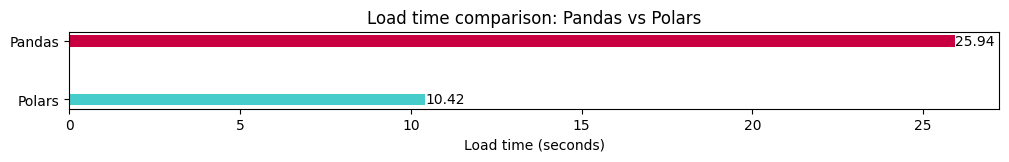

In [5]:
import pandas as pd
import polars as pl
import time as t

# measuring load time of pandas vs polars on largest csv file to estimate the upside of polars
file_path = data_files[1]  # assuming this is the largest file

pandas_start_time = t.time()
df_pd = pd.read_csv(file_path, delimiter='|', parse_dates=True, decimal=',',na_values=["", "#NO VALUE"])
pandas_end_time = t.time()
print(f"Pandas load time: {pandas_end_time - pandas_start_time:.2f} seconds")

polars_start_time = t.time()
df_pl = pl.read_csv(file_path, separator='|', try_parse_dates=True, decimal_comma=True, null_values=["", "#NO VALUE"])
polars_end_time = t.time()
print(f"Polars load time: {polars_end_time - polars_start_time:.2f} seconds")

# visualize with horizontal bar chart
import matplotlib.pyplot as plt
import numpy as np
labels = ['Pandas', 'Polars']
load_times = [pandas_end_time - pandas_start_time, polars_end_time - polars_start_time]

x = np.arange(len(labels))
width = 0.2

# color map
color_polars = "#47CCCC"
color_pandas = "#C80041"

fig, ax = plt.subplots(figsize=(12, 1))
bars = ax.barh(x, load_times, width, align='center', color=[color_pandas, color_polars])
ax.set_yticks(x)
ax.set_yticklabels(labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Load time (seconds)')
ax.set_title('Load time comparison: Pandas vs Polars')

# add data labels
for bar in bars:
    ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', va='center')

plt.show()